In [14]:
#GENAI PIONEER LABS
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

In [15]:
# Simulate dataset
def generate_data(n=200, img_size=64):
    X, y = [], []
    for i in range(n):
        img = np.random.rand(img_size, img_size)
        label = 0  # non-defective
        if i % 2 == 0:
            cv2.line(img, (5, 5), (50, 50), 1, 1)  # add defect
            label = 1
        X.append(img)
        y.append(label)
    return np.array(X).reshape(-1, img_size, img_size, 1), np.array(y)

In [16]:
import os
import cv2
import numpy as np

# load
X, y = generate_data(n=100) # Use simulated data instead of loading from a folder

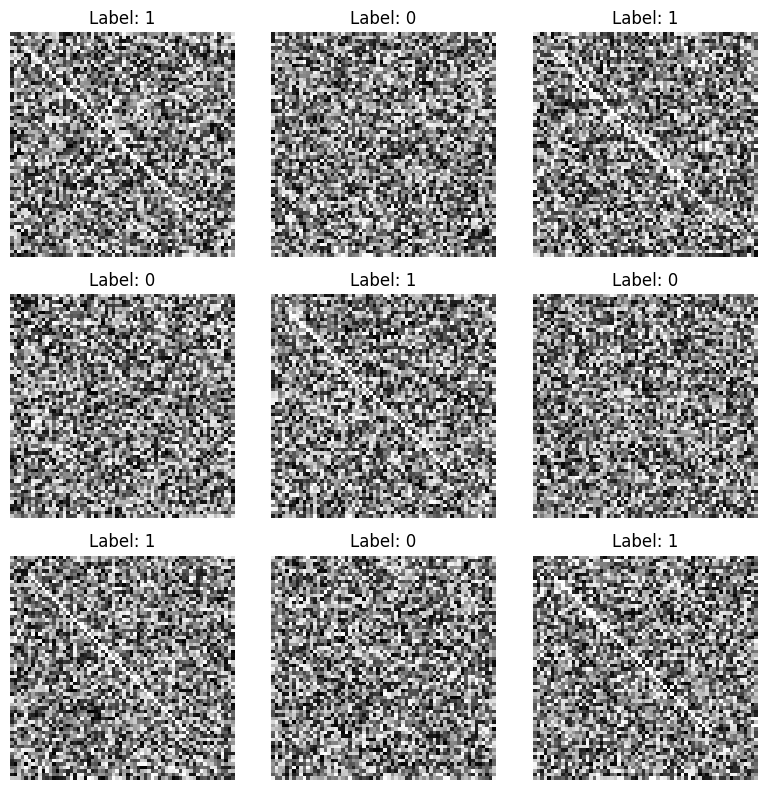

In [17]:
import matplotlib.pyplot as plt

# show first 9 images
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X[i].squeeze(), cmap='gray')
    plt.title(f"Label: {y[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

input_img = Input(shape=(64,64,1))

# Encoder
x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

# Decoder
x = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train on *normal* images only
normal_idx = np.where(y == 0)[0]
X_normal = X[normal_idx]

autoencoder.fit(X_normal, X_normal, epochs=10, batch_size=16, validation_split=0.2)

# calculate reconstruction error on ALL images
X_pred = autoencoder.predict(X)
reconstruction_error = np.mean((X - X_pred)**2, axis=(1,2,3))

# threshold can be picked by percentile or validation:
threshold = np.percentile(reconstruction_error, 95)

anomalies = np.where(reconstruction_error > threshold)[0]
print(f"Detected {len(anomalies)} anomalies out of {len(X)} images.")


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - loss: 0.0837 - val_loss: 0.0843
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0835 - val_loss: 0.0840
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0832 - val_loss: 0.0840
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0831 - val_loss: 0.0840
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0831 - val_loss: 0.0839
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0829 - val_loss: 0.0839
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0830 - val_loss: 0.0838
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0830 - val_loss: 0.0838
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0831 - val_loss: 0.0838
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0830 - val_loss: 0.0838


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Detected 5 anomalies out of 100 images.


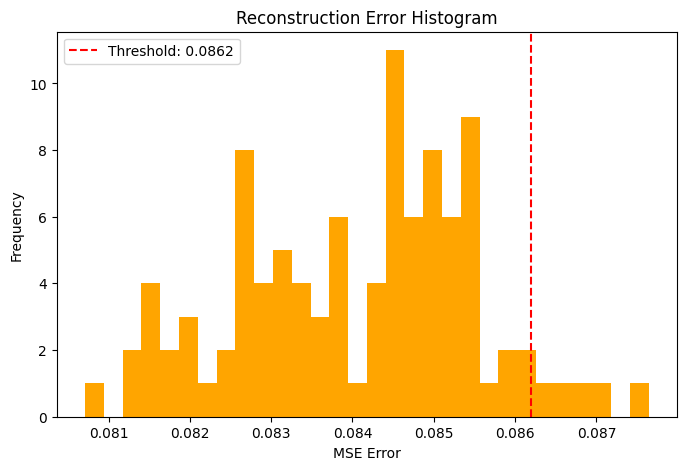

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(reconstruction_error, bins=30, color='orange')
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.title("Reconstruction Error Histogram")
plt.xlabel("MSE Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()


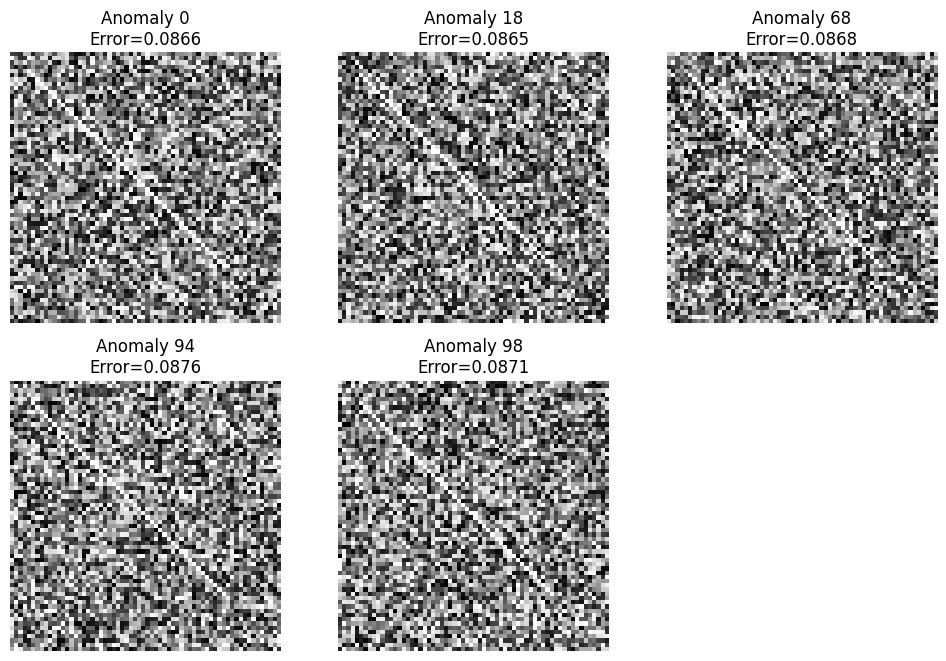

In [20]:
n_show = min(9, len(anomalies))
plt.figure(figsize=(10,10))
for idx, anomaly_idx in enumerate(anomalies[:n_show]):
    plt.subplot(3,3,idx+1)
    plt.imshow(X[anomaly_idx].squeeze(), cmap='gray')
    plt.title(f"Anomaly {anomaly_idx}\nError={reconstruction_error[anomaly_idx]:.4f}")
    plt.axis('off')
plt.tight_layout()
plt.show()
